In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
from pydub.silence import split_on_silence
from pydub import AudioSegment, effects 
from scipy.io.wavfile import read, write

C:\Users\Kavya Duvvuri\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


def preprocess_audio(audio_file_name):

    audio_file, sr = librosa.load(audio_file_name)
    
    audio_file = librosa.effects.preemphasis(audio_file)
    audio_file = librosa.effects.trim(audio_file, top_db=20)[0]
    audio_file = librosa.util.normalize(audio_file)
    
    return sr, audio_file

In [3]:
DATA_PATH = r"D:/Datasets/Speech Processing/Data/"

def get_file_names(path = DATA_PATH):
    file_names = os.listdir(path)
    return file_names

def process_audio(audio_file_name):
    rate, audio = read(f"./Data/{audio_file_name}")

    aud = AudioSegment(audio.tobytes(), frame_rate = rate,
                         sample_width = audio.dtype.itemsize, channels = 1)

    audio_chunks = split_on_silence(
        aud,
        min_silence_len = 1000,
        silence_thresh = -50,
        keep_silence = 500,)
    
    # audio chunks are combined here
    audio_processed = sum(audio_chunks)
    audio_processed = np.array(audio_processed.get_array_of_samples())
    audio_file = audio_file_name.split(".")[0]
    write(f"./Processed Data/{audio_file}_PROCESSED.wav", rate, audio_processed)

file_names = get_file_names()
for file_name in file_names:
    process_audio(file_name)
print("Done")

In [4]:
def get_label_dict(df, file_list, test=False):
    label_dict = {}
    
    if test:
        df_list = df['PHQ_Score']
    else:
        df_list = df['PHQ8_Score']

    for file in file_list:
        patient_num = int(file.split("/")[-1].split("_")[0])

        patient_list = list(df['Participant_ID'])

        idx = patient_list.index(patient_num)

        phq8_score = int(df_list[idx])
        
        if phq8_score in range(0, 6):
            score = 0
        elif phq8_score in range(6, 15):
            score = 1
        elif phq8_score in range(15, 22):
            score = 2
        elif phq8_score in range(22, 28):
            score = 3

        label_dict[f"{file}"] = score
    
    return label_dict

In [6]:
def get_set(df):
    df_files = [f"D:/Datasets/Speech Processing/Processed Data/{x}_AUDIO_PROCESSED.wav" for x in df['Participant_ID']]

    return list(set(df_files))

In [7]:
train_df, test_df, val_df = pd.read_csv(f"./train.csv"), pd.read_csv(f"./test.csv"), pd.read_csv(f"./val.csv")

train, test, val = get_set(train_df), get_set(test_df), get_set(val_df)

In [8]:
train_dict, test_dict, val_dict = get_label_dict(train_df, train), get_label_dict(test_df, test, True), get_label_dict(val_df, val)
data_dict = {**train_dict, **test_dict, **val_dict}

In [9]:
PROCESSED_DATA_PATH = r"D:/Datasets/Speech Processing/Processed Data/"

In [10]:
data_list = list(data_dict.keys())
label_list = list(data_dict.values())

In [11]:
new_data_list = []
new_label_list = []
for data in data_list:
    audios = os.listdir(PROCESSED_DATA_PATH)
    data_2 = data.split('/')[2]
    if data_2 in audios:
        new_data_list.append(data)
        new_label_list.append(label_list[data_list.index(data)])

In [13]:
csv_path = "./Data Labels.csv"
data_df = pd.read_csv(csv_path)
new_data = list(data_df["New Data"])
new_labels = list(data_df["New Labels"])

In [14]:
csv_path = "./Combined Features.csv"
combined_df = pd.read_csv(csv_path)
combined = list(combined_df["Combined"])
combined_features = []
for i in combined:
    new_i = i.replace('\n', ' ')
    new_i = new_i.replace('[', '')
    new_i = new_i.replace(']', '')
    array_data = np.fromstring(new_i, dtype=np.float64, sep=' ')
    combined_features.append(array_data)
print(len(combined_features[0]))

90


In [15]:
X = np.array(combined_features).reshape(744, 90, 1)

In [17]:
Y = np.array(new_labels)

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

In [19]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.20)

In [20]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(90,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [21]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_X, train_Y, epochs = 200, validation_data = (test_X, test_Y))

Epoch 1/200
19/19 [==============================] - 3s 40ms/step - loss: 2.3553 - accuracy: 0.4218 - val_loss: 1.4889 - val_accuracy: 0.4832
Epoch 2/200
19/19 [==============================] - 0s 16ms/step - loss: 1.4460 - accuracy: 0.4235 - val_loss: 1.1469 - val_accuracy: 0.4832
Epoch 3/200
19/19 [==============================] - 0s 16ms/step - loss: 1.2690 - accuracy: 0.4504 - val_loss: 1.0583 - val_accuracy: 0.4832
Epoch 4/200
19/19 [==============================] - 0s 16ms/step - loss: 1.1393 - accuracy: 0.4807 - val_loss: 1.0617 - val_accuracy: 0.4631
Epoch 5/200
19/19 [==============================] - 0s 16ms/step - loss: 1.1420 - accuracy: 0.4538 - val_loss: 1.0308 - val_accuracy: 0.4497
Epoch 6/200
19/19 [==============================] - 0s 17ms/step - loss: 1.0991 - accuracy: 0.4538 - val_loss: 1.0969 - val_accuracy: 0.4832
Epoch 7/200
19/19 [==============================] - 0s 17ms/step - loss: 1.1134 - accuracy: 0.4437 - val_loss: 1.0312 - val_accuracy: 0.4832
Epoch 

19/19 [==============================] - 0s 19ms/step - loss: 0.9670 - accuracy: 0.5244 - val_loss: 0.9953 - val_accuracy: 0.4966
Epoch 59/200
19/19 [==============================] - 0s 17ms/step - loss: 0.9643 - accuracy: 0.5328 - val_loss: 1.0078 - val_accuracy: 0.4832
Epoch 60/200
19/19 [==============================] - 0s 18ms/step - loss: 0.9790 - accuracy: 0.5210 - val_loss: 1.0111 - val_accuracy: 0.4966
Epoch 61/200
19/19 [==============================] - 0s 19ms/step - loss: 0.9661 - accuracy: 0.5143 - val_loss: 0.9972 - val_accuracy: 0.4966
Epoch 62/200
19/19 [==============================] - 0s 18ms/step - loss: 0.9677 - accuracy: 0.5227 - val_loss: 0.9800 - val_accuracy: 0.5101
Epoch 63/200
19/19 [==============================] - 0s 18ms/step - loss: 0.9584 - accuracy: 0.5294 - val_loss: 0.9957 - val_accuracy: 0.5101
Epoch 64/200
19/19 [==============================] - 0s 18ms/step - loss: 0.9678 - accuracy: 0.5294 - val_loss: 1.0081 - val_accuracy: 0.4899
Epoch 65/200

19/19 [==============================] - 0s 17ms/step - loss: 0.8996 - accuracy: 0.5597 - val_loss: 0.9460 - val_accuracy: 0.5436
Epoch 116/200
19/19 [==============================] - 0s 18ms/step - loss: 0.9013 - accuracy: 0.5597 - val_loss: 0.9468 - val_accuracy: 0.5235
Epoch 117/200
19/19 [==============================] - 0s 16ms/step - loss: 0.8771 - accuracy: 0.5731 - val_loss: 0.9980 - val_accuracy: 0.5235
Epoch 118/200
19/19 [==============================] - 0s 16ms/step - loss: 0.8883 - accuracy: 0.5513 - val_loss: 0.9499 - val_accuracy: 0.4899
Epoch 119/200
19/19 [==============================] - 0s 16ms/step - loss: 0.8753 - accuracy: 0.5714 - val_loss: 0.9339 - val_accuracy: 0.5369
Epoch 120/200
19/19 [==============================] - 0s 16ms/step - loss: 0.8810 - accuracy: 0.5697 - val_loss: 0.9599 - val_accuracy: 0.5168
Epoch 121/200
19/19 [==============================] - 0s 16ms/step - loss: 0.8691 - accuracy: 0.5681 - val_loss: 0.9226 - val_accuracy: 0.5302
Epoch 

Epoch 172/200
19/19 [==============================] - 0s 16ms/step - loss: 0.7511 - accuracy: 0.6387 - val_loss: 0.9598 - val_accuracy: 0.5839
Epoch 173/200
19/19 [==============================] - 0s 16ms/step - loss: 0.7576 - accuracy: 0.6437 - val_loss: 1.0056 - val_accuracy: 0.5436
Epoch 174/200
19/19 [==============================] - 0s 16ms/step - loss: 0.7707 - accuracy: 0.6303 - val_loss: 0.9739 - val_accuracy: 0.5570
Epoch 175/200
19/19 [==============================] - 0s 16ms/step - loss: 0.7564 - accuracy: 0.6639 - val_loss: 0.9896 - val_accuracy: 0.5503
Epoch 176/200
19/19 [==============================] - 0s 18ms/step - loss: 0.7769 - accuracy: 0.6487 - val_loss: 0.9646 - val_accuracy: 0.5503
Epoch 177/200
19/19 [==============================] - 0s 16ms/step - loss: 0.7575 - accuracy: 0.6387 - val_loss: 1.0111 - val_accuracy: 0.5302
Epoch 178/200
19/19 [==============================] - 0s 16ms/step - loss: 0.7675 - accuracy: 0.6303 - val_loss: 0.9604 - val_accuracy:

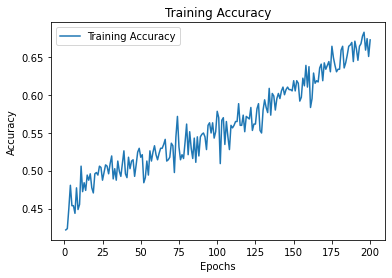

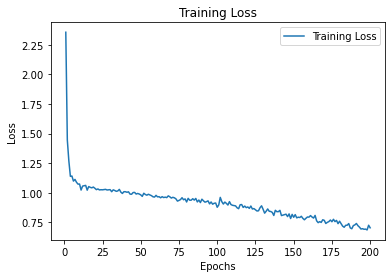

In [22]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import Multiply, Activation, Lambda, Permute
import keras.backend as K

def attention_block(inputs):
    a = Dense(1, activation='tanh')(inputs)
    a = Flatten()(a)
    a = Activation('softmax')(a)
    a = Lambda(lambda x: K.expand_dims(x, axis=-1))(a)
    output_attention_mul = Multiply()([inputs, a])
    return output_attention_mul

# input size is based on 1D data; adjust if you use other features
num_features = 90
num_classes = 4
input_shape = (num_features, 1)

inputs = Input(shape=input_shape)

# Convolutional layers
conv = Conv1D(32, kernel_size=5, activation='relu')(inputs)
conv = MaxPooling1D(pool_size=2)(conv)
conv = Conv1D(64, kernel_size=5, activation='relu')(conv)
conv = MaxPooling1D(pool_size=2)(conv)
conv = Conv1D(128, kernel_size=5, activation='relu')(conv)

# LSTM layers
lstm_output = LSTM(128, return_sequences=True)(conv)

# Attention layer
attention_output = attention_block(lstm_output)

# Fully connected layer
fc = Flatten()(attention_output)
fc = Dense(128, activation='relu')(fc)
fc = Dropout(0.5)(fc)
fc = Dense(num_classes, activation='softmax')(fc)

model = Model(inputs=[inputs], outputs=[fc])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.fit(train_X, train_Y, epochs = 200, validation_data = (test_X, test_Y))

Epoch 1/200
19/19 [==============================] - 7s 96ms/step - loss: 1.1355 - accuracy: 0.5008 - val_loss: 1.0367 - val_accuracy: 0.4832
Epoch 2/200
19/19 [==============================] - 1s 41ms/step - loss: 1.0663 - accuracy: 0.4639 - val_loss: 1.0394 - val_accuracy: 0.4832
Epoch 3/200
19/19 [==============================] - 1s 41ms/step - loss: 1.0608 - accuracy: 0.4672 - val_loss: 1.0399 - val_accuracy: 0.4832
Epoch 4/200
19/19 [==============================] - 1s 39ms/step - loss: 1.0496 - accuracy: 0.4958 - val_loss: 1.0390 - val_accuracy: 0.4832
Epoch 5/200
19/19 [==============================] - 1s 40ms/step - loss: 1.0602 - accuracy: 0.4672 - val_loss: 1.0339 - val_accuracy: 0.4832
Epoch 6/200
19/19 [==============================] - 1s 39ms/step - loss: 1.0564 - accuracy: 0.5076 - val_loss: 1.0366 - val_accuracy: 0.4832
Epoch 7/200
19/19 [==============================] - 1s 42ms/step - loss: 1.0358 - accuracy: 0.5076 - val_loss: 1.0360 - val_accuracy: 0.4832
Epoch 

19/19 [==============================] - 1s 40ms/step - loss: 0.2992 - accuracy: 0.8588 - val_loss: 1.2345 - val_accuracy: 0.6980
Epoch 59/200
19/19 [==============================] - 1s 41ms/step - loss: 0.2949 - accuracy: 0.8672 - val_loss: 1.3763 - val_accuracy: 0.6846
Epoch 60/200
19/19 [==============================] - 1s 40ms/step - loss: 0.3177 - accuracy: 0.8538 - val_loss: 1.3216 - val_accuracy: 0.6510
Epoch 61/200
19/19 [==============================] - 1s 40ms/step - loss: 0.2893 - accuracy: 0.8605 - val_loss: 1.3720 - val_accuracy: 0.7047
Epoch 62/200
19/19 [==============================] - 1s 41ms/step - loss: 0.3274 - accuracy: 0.8521 - val_loss: 1.4068 - val_accuracy: 0.6577
Epoch 63/200
19/19 [==============================] - 1s 41ms/step - loss: 0.3128 - accuracy: 0.8471 - val_loss: 1.2298 - val_accuracy: 0.7315
Epoch 64/200
19/19 [==============================] - 1s 42ms/step - loss: 0.3166 - accuracy: 0.8504 - val_loss: 1.2859 - val_accuracy: 0.7114
Epoch 65/200

19/19 [==============================] - 1s 41ms/step - loss: 0.1977 - accuracy: 0.9092 - val_loss: 1.6544 - val_accuracy: 0.7315
Epoch 116/200
19/19 [==============================] - 1s 41ms/step - loss: 0.1832 - accuracy: 0.9210 - val_loss: 1.7415 - val_accuracy: 0.7114
Epoch 117/200
19/19 [==============================] - 1s 41ms/step - loss: 0.1774 - accuracy: 0.9160 - val_loss: 1.8362 - val_accuracy: 0.7114
Epoch 118/200
19/19 [==============================] - 1s 40ms/step - loss: 0.1915 - accuracy: 0.9143 - val_loss: 1.7743 - val_accuracy: 0.7248
Epoch 119/200
19/19 [==============================] - 1s 39ms/step - loss: 0.1844 - accuracy: 0.9176 - val_loss: 1.9128 - val_accuracy: 0.6711
Epoch 120/200
19/19 [==============================] - 1s 40ms/step - loss: 0.1782 - accuracy: 0.9176 - val_loss: 1.8359 - val_accuracy: 0.7114
Epoch 121/200
19/19 [==============================] - 1s 39ms/step - loss: 0.1703 - accuracy: 0.9277 - val_loss: 2.2199 - val_accuracy: 0.6711
Epoch 

Epoch 172/200
19/19 [==============================] - 1s 39ms/step - loss: 0.0907 - accuracy: 0.9546 - val_loss: 2.2517 - val_accuracy: 0.7315
Epoch 173/200
19/19 [==============================] - 1s 39ms/step - loss: 0.1059 - accuracy: 0.9546 - val_loss: 2.2595 - val_accuracy: 0.7315
Epoch 174/200
19/19 [==============================] - 1s 39ms/step - loss: 0.0896 - accuracy: 0.9664 - val_loss: 2.2861 - val_accuracy: 0.7248
Epoch 175/200
19/19 [==============================] - 1s 40ms/step - loss: 0.1089 - accuracy: 0.9412 - val_loss: 2.3589 - val_accuracy: 0.7584
Epoch 176/200
19/19 [==============================] - 1s 38ms/step - loss: 0.1605 - accuracy: 0.9361 - val_loss: 2.1726 - val_accuracy: 0.7450
Epoch 177/200
19/19 [==============================] - 1s 40ms/step - loss: 0.1492 - accuracy: 0.9462 - val_loss: 2.0835 - val_accuracy: 0.6913
Epoch 178/200
19/19 [==============================] - 1s 40ms/step - loss: 0.1384 - accuracy: 0.9513 - val_loss: 1.7839 - val_accuracy: